<a href="https://colab.research.google.com/github/dgwalters-1974/autoencoder/blob/main/autoencoder_sf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook closely follows the method outlined in the 'Fraud Detection Handbook' online repo, with a few modifications. Most significantly the data used is real world rather than generated and the variables within are of a different nature (all numerical). Other tweaks to the learning rate, training loops, loss functions etc may deviate from the repo as this repo was essentially an sandbox for playing with ideas and an attempt to use an autoencoder structure to replicate earlier results at detecting anomalies in financial data with more traditional ML algorithms.

Import relevant modules...

# Imports and Data Transformation

In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import random
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler


Load data from csv file (need to copy into filespace if not there already)

In [372]:
df = pd.read_csv('/content/sample_data/fixings_SmartXM_no empty_max indices.csv')
df.reset_index()
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df = df.dropna().sort_index(ascending=True)
df = df.set_index('Date').sort_index(ascending=True)

Rescale data...

In [373]:
def rescale_df(dataframe, min, max):
  scaler = MinMaxScaler(feature_range=(min, max))
  data_scaled = scaler.fit_transform(df)
  df_scaled = pd.DataFrame(data_scaled, columns=df.columns, index=df.index)
  return df_scaled

df = rescale_df(df, -1, 1)
df.head()

,AED-EIBOR-12M,AED-EIBOR-1M,AED-EIBOR-3M,AED-EIBOR-6M,AUD-AONIA,AUD-BBSW-1M,AUD-BBSW-3M,AUD-BBSW-6M,BRL-CDI,CAD-CDOR-1M,...,THB-THOR,TRY-TLREF,TRY-TRLIBOR-3M,TWD-TAIBOR-3M,USD-FED-FUND,USD-LIBOR-1M,USD-LIBOR-3M,USD-LIBOR-6M,USD-SOFR,ZAR-JIBAR-3M
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,-0.281205,-0.322375,-0.268805,-0.302489,-0.671815,-0.596867,-0.591707,-0.572581,-0.574468,-0.339281,...,-0.249195,-0.830272,-0.954478,-0.655903,-0.429112,-0.375010,-0.328907,-0.355017,-0.428571,0.339903
2020-01-02,-0.283975,-0.353649,-0.287949,-0.292048,-0.671815,-0.596867,-0.587171,-0.619645,-0.574468,-0.338290,...,-0.253324,-0.838797,-0.959333,-0.655712,-0.429112,-0.385410,-0.331766,-0.355904,-0.432282,0.339903
2020-01-03,-0.283975,-0.353649,-0.287949,-0.292048,-0.671815,-0.596867,-0.593975,-0.623824,-0.574468,-0.339281,...,-0.244261,-0.841637,-0.953012,-0.655903,-0.429112,-0.392855,-0.341039,-0.361510,-0.428571,0.339903
2020-01-06,-0.269640,-0.342527,-0.305228,-0.307498,-0.671815,-0.595708,-0.593975,-0.625914,-0.574468,-0.341760,...,-0.244410,-0.811738,-0.948685,-0.655712,-0.429112,-0.401036,-0.341612,-0.361048,-0.428571,0.339903
2020-01-07,-0.270578,-0.353340,-0.304749,-0.315393,-0.671815,-0.593205,-0.596244,-0.628004,-0.574468,-0.344238,...,-0.247328,-0.786922,-0.952483,-0.656095,-0.429112,-0.398495,-0.339590,-0.365686,-0.424861,0.339903


In [374]:
input_features = list(df.columns)

These cells are optional. The original model was trained on 70+ features and returned strange results (increasing loss on both training and validation sets) and so here we can reduce the number of variables to simplify the model and try to figure out what is going on.

In [375]:
input_features = [x for x in input_features if 'EUR' in x]

In [376]:
df = df[input_features]

Load helper functions from Fraud Detection Handbook GitHub pages. Maybe hard code these locally as only a couple used.

In [377]:
# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   360k      0 --:--:-- --:--:-- --:--:--  361k


<Figure size 640x480 with 0 Axes>

In [378]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cpu


Set seed across all libraries

In [379]:
SEED = 74
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Dataset and Dataloader

In [380]:
def get_train_test_set_(df, start_train, end_train):
  train_df = df[(df.index>=start_train) & (df.index<=end_train)]
  test_df = df[(df.index>end_train)]
  return train_df, test_df
train_df, valid_df = get_train_test_set_(df, start_train='2020-01-01', end_train='2023-07-03')

In [381]:
train_df.shape, valid_df.shape

((914, 6), (240, 6))

In [382]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
# y_train = torch.FloatTensor(train_df[output_feature].values)
# y_valid = torch.FloatTensor(valid_df[output_feature].values)

Create dataset object

In [383]:
class FraudDatasetUnsupervised(torch.utils.data.Dataset):

    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index].to(DEVICE)
        if self.output:
            return item, item
        else:
            return item

In [384]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

Create generator objects for training and validation datasets

In [385]:
training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)


# Build Model and Training Loop

In [386]:
class SimpleAutoencoder(torch.nn.Module):

        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size
            self.code_size  = code_size

            self.relu = torch.nn.ReLU()

            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)

            #decoder
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)


        def forward(self, x):

            hidden = self.fc1(x)
            hidden = self.relu(hidden)

            code = self.fc2(hidden)
            code = self.relu(code)

            hidden = self.fc3(code)
            hidden = self.relu(hidden)

            output = self.fc4(hidden)
            #linear activation in final layer)

            return output


Define loss function

In [387]:
criterion = torch.nn.MSELoss().to(DEVICE)


In [388]:
def per_sample_mse(model, generator):

    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []

    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)

    return batch_losses

In [389]:
seed_everything(SEED)
model = SimpleAutoencoder(x_train.shape[1], 100, 20).to(DEVICE)
losses = per_sample_mse(model, valid_generator)

In [390]:
print(losses[0:5])
print(np.mean(losses))

[0.6797409, 0.6784718, 0.67994136, 0.69808704, 0.6997523]
0.78513557


In [391]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Run Model & check results

In [402]:
model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=500,
                                                                        verbose=True)



Epoch 0: train loss: 0.6023966153462728
valid loss: 0.7938341796398163
New best score: 0.7938341796398163

Epoch 1: train loss: 0.5613600055376688
valid loss: 0.7881338745355606
New best score: 0.7881338745355606

Epoch 2: train loss: 0.5202295660972596
valid loss: 0.7829685658216476
New best score: 0.7829685658216476

Epoch 3: train loss: 0.4779345691204071
valid loss: 0.7755495607852936
New best score: 0.7755495607852936

Epoch 4: train loss: 0.4297563095887502
valid loss: 0.7637767940759659
New best score: 0.7637767940759659

Epoch 5: train loss: 0.38366323709487915
valid loss: 0.7460369765758514
New best score: 0.7460369765758514

Epoch 6: train loss: 0.3293953855832418
valid loss: 0.7166260927915573
New best score: 0.7166260927915573

Epoch 7: train loss: 0.27665139536062877
valid loss: 0.6759603023529053
New best score: 0.6759603023529053

Epoch 8: train loss: 0.2256517877181371
valid loss: 0.6216063648462296
New best score: 0.6216063648462296

Epoch 9: train loss: 0.17985893487

In [393]:
losses = per_sample_mse(model, valid_generator)
print(losses[0:5])
print(np.mean(losses))

[0.6831143, 0.68178874, 0.68334705, 0.70113117, 0.70280725]
0.79573184


In [394]:
print(x_train[0])
print(model(x_train[0].to(DEVICE)))

tensor([ 0.7353, -0.9725, -0.8866, -0.9076, -0.9036, -0.9021])
tensor([-0.1791, -0.0346, -0.0481, -0.0010, -0.0690, -0.0136],
       grad_fn=<ViewBackward0>)


In [395]:
predictions_df=valid_df
predictions_df['predictions']=losses

predictions_df.sort_values('predictions', ascending=False).head(10)

,EUR-EONIA,EUR-ESTR,EUR-EURIBOR-12M,EUR-EURIBOR-1M,EUR-EURIBOR-3M,EUR-EURIBOR-6M,predictions
Date,,,,,,,
2023-10-18,-1.0,0.995561,0.986515,0.986353,0.996093,1.000000,0.891579
2023-10-19,-1.0,0.996449,0.981458,0.982390,1.000000,0.992761,0.888370
2023-09-25,-1.0,0.996005,0.991572,0.986793,0.989147,0.991058,0.887941
2023-09-27,-1.0,0.996449,0.988201,0.983711,0.986976,0.997019,0.887310
2023-10-09,-1.0,0.994230,0.982722,0.989434,0.990449,0.994039,0.887142
2023-10-03,-1.0,0.994230,0.991572,0.989875,0.983503,0.993613,0.887120
2023-10-06,-1.0,0.993786,0.985672,0.985912,0.991752,0.987226,0.885057
2023-09-28,-1.0,0.996893,0.997050,0.977988,0.979596,0.992336,0.884076
2023-10-13,-1.0,0.995561,0.975980,0.984592,0.992620,0.990632,0.883932


(array([ 6., 15.,  3., 38., 46., 63., 15.,  4., 24., 26.]),
 array([0.68178874, 0.70276779, 0.72374678, 0.74472582, 0.76570481,
        0.78668386, 0.8076629 , 0.82864189, 0.84962094, 0.87059993,
        0.89157897]),
 <BarContainer object of 10 artists>)

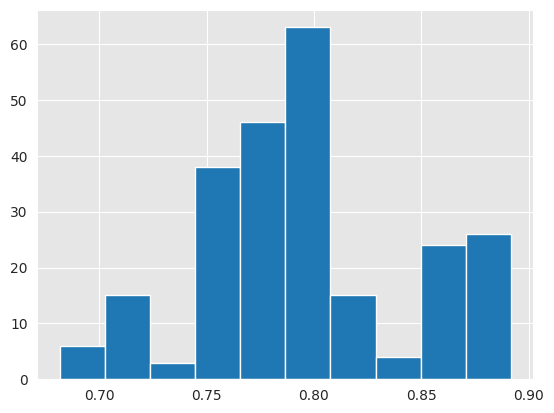

In [396]:
plt.hist(predictions_df['predictions'])

In [397]:
predictions_df.sort_values('predictions', ascending=False).head(10)

,EUR-EONIA,EUR-ESTR,EUR-EURIBOR-12M,EUR-EURIBOR-1M,EUR-EURIBOR-3M,EUR-EURIBOR-6M,predictions
Date,,,,,,,
2023-10-18,-1.0,0.995561,0.986515,0.986353,0.996093,1.000000,0.891579
2023-10-19,-1.0,0.996449,0.981458,0.982390,1.000000,0.992761,0.888370
2023-09-25,-1.0,0.996005,0.991572,0.986793,0.989147,0.991058,0.887941
2023-09-27,-1.0,0.996449,0.988201,0.983711,0.986976,0.997019,0.887310
2023-10-09,-1.0,0.994230,0.982722,0.989434,0.990449,0.994039,0.887142
2023-10-03,-1.0,0.994230,0.991572,0.989875,0.983503,0.993613,0.887120
2023-10-06,-1.0,0.993786,0.985672,0.985912,0.991752,0.987226,0.885057
2023-09-28,-1.0,0.996893,0.997050,0.977988,0.979596,0.992336,0.884076
2023-10-13,-1.0,0.995561,0.975980,0.984592,0.992620,0.990632,0.883932


In [398]:
from sklearn.ensemble import IsolationForest

anomalyclassifier = IsolationForest(random_state=SEED, n_estimators=10)
anomalyclassifier.fit(train_df[input_features])

IsolationForest(n_estimators=10, random_state=74)

In [399]:
predictions_df = valid_df
predictions_df['predictions'] = -anomalyclassifier.score_samples(valid_df[input_features])
predictions_df.sort_values('predictions')

,EUR-EONIA,EUR-ESTR,EUR-EURIBOR-12M,EUR-EURIBOR-1M,EUR-EURIBOR-3M,EUR-EURIBOR-6M,predictions
Date,,,,,,,
2024-02-26,-1.0,0.996005,0.790982,0.977108,0.978294,0.896956,0.657386
2024-02-23,-1.0,0.997337,0.793510,0.980630,0.970046,0.902491,0.657386
2024-02-27,-1.0,0.996449,0.792246,0.982390,0.978294,0.904194,0.657386
2024-02-28,-1.0,0.996893,0.797724,0.982831,0.973953,0.902917,0.657386
2024-02-29,-1.0,0.988460,0.798146,0.986793,0.971782,0.899936,0.657386
...,...,...,...,...,...,...,...
2023-10-23,-1.0,0.996449,0.965023,0.985032,0.980030,0.979987,0.688303
2023-10-20,-1.0,0.996449,0.981879,0.985912,0.985674,0.984671,0.688303
2023-08-28,-1.0,0.883711,0.933418,0.889941,0.899718,0.915265,0.688303


(array([21., 26., 50., 56.,  0.,  5., 11.,  0., 70.,  1.]),
 array([0.65738626, 0.66094524, 0.66450423, 0.66806321, 0.67162219,
        0.67518117, 0.67874015, 0.68229913, 0.68585812, 0.6894171 ,
        0.69297608]),
 <BarContainer object of 10 artists>)

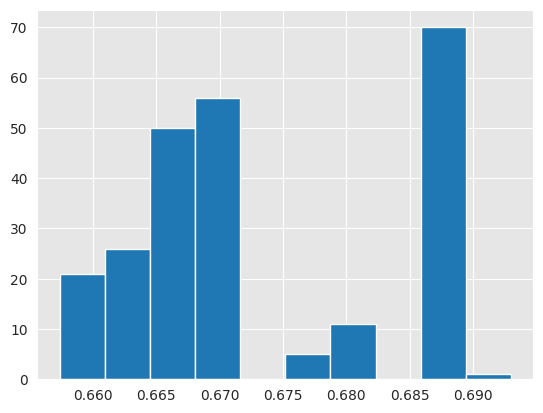

In [400]:
plt.hist(predictions_df['predictions'])

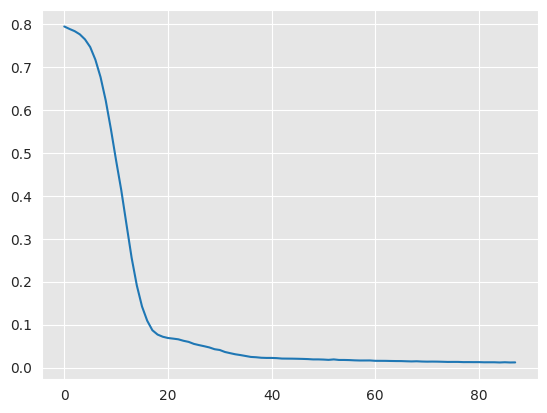

In [404]:
plt.plot(valid_losses)